In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import pickle
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=20)

# File handling
from pathlib import Path

# Progress tracking
from tqdm.notebook import tqdm

# Statistics
from scipy.stats import percentileofscore

# Chemistry
import pubchempy as pcp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import os
working_dir = Path('/home/fcarli/CellSense/figures/')
os.chdir(working_dir)

In [3]:
dataset = 'gdsc'
data_path = Path.cwd().parent / 'data'
#results_path = Path.cwd().parent / 'results'/ dataset / 'full_inference_results'
results_path = Path.cwd().parent / 'results'/ dataset / 'full_inference_all_paths'

In [4]:
#set from where to load the predictions of the single drug models
dataset = 'gdsc'
data_path = Path.cwd().parent / 'data'

celligner_used = 'old'

if celligner_used == 'old':
    results_path = Path('/home/fcarli/CellSense/results/gdsc/full_inference_all_paths') #the old one

else:
    results_path = Path('/home/fcarli/WebCellHit/results/CellHit/inference/gdsc/predictions') #the new one

## Mapping indications onto GDSC drugs

In [5]:
#load the GDSC metadata data
gdsc_drugs = pd.read_csv(data_path / 'GDSC_drugs.csv')

In [6]:
#obtain the mapper from full length names to TCGA codes
tcga_schema = pd.read_csv(data_path / 'tcga_abbrev_table.csv')
tcga_schema = pd.Series(tcga_schema['Study Abbreviation'].values,index=tcga_schema['Study Name']).to_dict()

In [7]:
#load the NCI annotations directly from the LLM annotations
nci_path = Path('../open_llms/results/nci_annot')

dfs = []

for annot in nci_path.iterdir():

    if annot.suffix == '.pkl':

        with open(annot, 'rb') as f:
            nci_annot = pickle.load(f)

        tdf = pd.DataFrame()
        tdf['DrugName'] = [nci_annot['drug_name']]
        tdf['DrugAliases'] = [nci_annot['drug_aliases']]
        tdf['DrugIndications'] = [nci_annot['drug_indications']]

        dfs.append(tdf)

nci_drugs = pd.concat(dfs)
nci_drugs.head()

,DrugName,DrugAliases,DrugIndications
0,Moxetumomab Pasudotox-tdfk,N/A,[]
0,Methotrexate Sodium,None found,"[Breast invasive carcinoma, Head and Neck squa..."
0,Recombinant Human Papillomavirus (HPV) Quadriv...,N/A,[Cervical squamous cell carcinoma and endocerv...
0,Everolimus,"Afinitor, Afinitor Disperz, Votubia, Zortress","[Breast invasive carcinoma, Kidney renal clear..."
0,Alectinib,None found,[Lung adenocarcinoma]


In [8]:
#add the TCGA codes staring from the full length names of the tumor types
nci_drugs['DrugIndications'] = nci_drugs['DrugIndications'].apply(lambda x: [tcga_schema[i] for i in x if i in tcga_schema.keys()])
nci_drugs.head()

,DrugName,DrugAliases,DrugIndications
0,Moxetumomab Pasudotox-tdfk,N/A,[]
0,Methotrexate Sodium,None found,"[BRCA, HNSC, DLBC]"
0,Recombinant Human Papillomavirus (HPV) Quadriv...,N/A,[CESC]
0,Everolimus,"Afinitor, Afinitor Disperz, Votubia, Zortress","[BRCA, KIRC, LUAD, LUSC, PAAD]"
0,Alectinib,None found,[LUAD]


In [9]:
unique_projects = nci_drugs['DrugIndications'].explode().unique()
len(unique_projects)

31

In [10]:
def recoder(x):
    if x['DrugType'] == 'Compound':
        return f'C_{x["PubChemId"]}'
    else:
        return f'S_{x["PubChemId"]}'

In [11]:
#read the mappers from names to PubChem IDs (we will use PubChem IDs to map the indications)
#for NCI
nci_pubchem = pd.read_csv(data_path / 'nci_pubchem.csv')
nci_pubchem['id'] = nci_pubchem.apply(lambda x: recoder(x),axis=1)


In [12]:
#obtain the mapper from names to PubChem IDs
nci_name_to_id = dict(zip(nci_pubchem['DrugName'].values,nci_pubchem['id'].values))

#map the NCI drugs to PubChem IDs
nci_drugs['id'] = nci_drugs['DrugName'].apply(lambda x: nci_name_to_id[x] if x in nci_name_to_id.keys() else None)

#drop the drugs without PubChem IDs
nci_drugs = nci_drugs.dropna(subset=['id'])

#drop columns with len 0 in DrugIndications
nci_drugs = nci_drugs[nci_drugs['DrugIndications'].apply(lambda x: len(x)>0)]


nci_drugs.head()

,DrugName,DrugAliases,DrugIndications,id
0,Methotrexate Sodium,None found,"[BRCA, HNSC, DLBC]",C_126941
0,Everolimus,"Afinitor, Afinitor Disperz, Votubia, Zortress","[BRCA, KIRC, LUAD, LUSC, PAAD]",C_6442177
0,Alectinib,None found,[LUAD],C_49806720
0,Loncastuximab Tesirine-lpyl,N/A,[DLBC],S_381128138
0,FOLFIRI,N/A,"[COAD, READ]",C_136170999


In [13]:
#obtain a mapper from PubChem IDs to indications
indications_mapper = dict(zip(nci_drugs['id'].values,nci_drugs['DrugIndications'].values))

#this one is important since is the one that effectively maps the indications once the pubchem ids are known on gdsc drugs

Up to here we have nci_drugs with both PubChemIds and DrugIndications. Now we need to attach pubchem ids to the gdsc drugs so that we can transfer the indications

In [14]:
#for GDSC (this are precomputed separately)
gdsc_pubchem = pd.read_csv(data_path / 'gdsc_pubchem.csv')
gdsc_pubchem['id'] = gdsc_pubchem.apply(lambda x: recoder(x),axis=1)

#obtain a mapper from GDSC names to PubChem IDs
gdsc_pubchem_mapper = dict(zip(gdsc_pubchem['DrugName'].values,gdsc_pubchem['id'].values))

In [15]:
#add the PubChem IDs to the GDSC drugs
gdsc_drugs['id'] = gdsc_drugs['DRUG_NAME'].apply(lambda x: gdsc_pubchem_mapper[x] if x in gdsc_pubchem_mapper.keys() else None)
#drop the drugs without PubChem IDs
gdsc_drugs = gdsc_drugs.dropna(subset=['id'])

In [16]:
#finally map the indications on GDSC drugs
gdsc_drugs['DrugIndications'] = gdsc_drugs['id'].apply(lambda x: indications_mapper[x] if x in indications_mapper.keys() else None)
#drop the drugs without indications
gdsc_drugs = gdsc_drugs.dropna(subset=['DrugIndications'])

gdsc_drugs.head()

,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,DRUG_SYNONYMS,SMILES,HGCN_TARGETS,id,DrugIndications
1,1004,Vinblastine,Microtubule destabiliser,Mitosis,Velban,CC[C@@]1(C[C@H]2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC...,TUBB,C_13342,"[BRCA, TGCT]"
2,1005,Cisplatin,DNA crosslinker,DNA replication,"cis-Diammineplatinum(II) dichloride, Platinol,...",N.N.Cl[Pt]Cl,DNA,C_5702198,"[BLCA, OV, TGCT]"
3,1006,Cytarabine,Antimetabolite,Other,"Ara-Cytidine, Arabinosyl Cytosine, U-19920",C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...,DNA synthesis,C_6253,"[LAML, LCML]"
4,1007,Docetaxel,Microtubule stabiliser,Mitosis,"RP-56976, Taxotere",CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...,TUBB,C_148124,"[BRCA, HNSC, LUAD, LUSC, PAAD, PRAD, STAD]"
5,1008,Methotrexate,Antimetabolite,DNA replication,"Abitrexate, Amethopterin, Rheumatrex, Trexall,...",CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...,DHFR,C_126941,"[BRCA, HNSC, DLBC]"


In [17]:
final_annotations = gdsc_drugs[['DRUG_ID','id','DrugIndications','DRUG_NAME']]
final_annotations.columns = ['DRUG_ID','pubchem_id','Tumor code','Drug']
final_annotations = final_annotations.set_index('DRUG_ID')
final_annotations['Tumor code'] = final_annotations['Tumor code'].apply(lambda x: [i.strip() for i in x])
final_annotations['Tumor code'] = final_annotations['Tumor code'].apply(lambda x:set(x))
final_annotations['Tumor code'] = final_annotations['Tumor code'].apply(lambda x: ','.join(x))
final_annotations.head()

,pubchem_id,Tumor code,Drug
DRUG_ID,,,
1004,C_13342,"TGCT,BRCA",Vinblastine
1005,C_5702198,"BLCA,TGCT,OV",Cisplatin
1006,C_6253,"LCML,LAML",Cytarabine
1007,C_148124,"LUAD,PRAD,HNSC,LUSC,BRCA,PAAD,STAD",Docetaxel
1008,C_126941,"HNSC,DLBC,BRCA",Methotrexate


In [18]:
final_annotations.loc[1372]

pubchem_id    C_11707110
Tumor code      LGG,SKCM
Drug          Trametinib
Name: 1372, dtype: object

In [19]:
id_to_gdscName = pd.Series(gdsc_drugs['DRUG_NAME'].values, index=gdsc_drugs['DRUG_ID']).to_dict()
id_to_gdscName

#inverse mapper
gdscName_to_id = pd.Series(gdsc_drugs['DRUG_ID'].values, index=gdsc_drugs['DRUG_NAME']).to_dict()

In [20]:
final_annotations.loc[1909]

pubchem_id    C_49846579
Tumor code          LAML
Drug          Venetoclax
Name: 1909, dtype: object

# Processing TCGA predictions

Reading and processing clinical data from TCGA

In [21]:
#read the clinical data from TCGA
clinical_data = pd.read_csv(data_path / 'tcga_clinical.tsv', sep='\t')[['case_submitter_id','project_id']].drop_duplicates()

#keep only the TCGA-XX-XXXX format
clinical_data = clinical_data[clinical_data['case_submitter_id'].str.contains('TCGA-')]

#strip the TCGA- prefix from the tumor codes
clinical_data['project_id'] = clinical_data['project_id'].str.replace('TCGA-','')

clinical_data.head()

,case_submitter_id,project_id
0,TCGA-DD-AAVP,LIHC
3,TCGA-KK-A7B2,PRAD
7,TCGA-DC-6158,READ
9,TCGA-DD-A4NP,LIHC
11,TCGA-HQ-A5ND,BLCA


In [22]:
#pool together the predictions from all the single drug models
dfs = []

for drug in results_path.iterdir():
    
    #load predictions
    preds = pd.read_csv(drug)
    dfs.append(preds)
    
#concatenate all predictions
preds = pd.concat(dfs)

if celligner_used == 'old':
    preds.rename(columns={'DepMapID':'Index'},inplace=True)

#get the list of unique drugs
all_drugs = preds['DrugName'].unique()

preds.head()

,DrugName,DrugID,Predictions,Index
0,Afatinib,1032,2.153231,ACH-000668
1,Afatinib,1032,2.089345,ACH-000493
2,Afatinib,1032,2.018310,ACH-000574
3,Afatinib,1032,2.415240,ACH-000700
4,Afatinib,1032,1.706679,ACH-001193


In [23]:
#define the quintile computer that we will use later to recover the top predictions
class ScoreComputer(object):
    
    def __init__(self,metadata,
                 cell_col='Index',drug_col='DrugID',score_col='Predictions'):
        
        
        #-- cell distributions --
        temp = metadata[[cell_col,score_col]]
        temp = temp.groupby(cell_col)[score_col].agg(list)
        
        temp_dict = temp.to_dict()
        self.distrib_cells = {key: np.array(temp_dict[key]) for key in temp.index}
        
        #-- drug distributions --
        temp = metadata[[drug_col,score_col]]
        temp = temp.groupby(drug_col)[score_col].agg(list)
        
        temp_dict = temp.to_dict()
        self.distrib_drugs = {key: np.array(temp_dict[key]) for key in temp.index}

        
    def compute_score(self, drug, cell, score):
        
        #efficacy
        efficacy = 1-(percentileofscore(self.distrib_cells[cell], score)*0.01)
        
        #selectivity
        selectivity = 1-(percentileofscore(self.distrib_drugs[drug], score)*0.01)
        
        #score as harmonic mean of efficacy and selectivity
        score = 2*(efficacy*selectivity)/(efficacy+selectivity)
        
        return score

In [24]:
#initialize stats and compute the quantiles to the predictions
computer = ScoreComputer(preds)
preds['QuantileScore'] = preds.parallel_apply(lambda x: computer.compute_score(x['DrugID'],x['Index'],x['Predictions']),axis=1)

/tmp/ipykernel_72820/663763258.py:32: RuntimeWarning: invalid value encountered in scalar divide
  score = 2*(efficacy*selectivity)/(efficacy+selectivity)


We merge clinical information from TCGA 

In [25]:
preds.head()

,DrugName,DrugID,Predictions,Index,QuantileScore
0,Afatinib,1032,2.153231,ACH-000668,0.361895
1,Afatinib,1032,2.089345,ACH-000493,0.407050
2,Afatinib,1032,2.018310,ACH-000574,0.447428
3,Afatinib,1032,2.415240,ACH-000700,0.226155
4,Afatinib,1032,1.706679,ACH-001193,0.600096


In [26]:
#strip last three characters from DepMapID to pass from sample_id to submitter_id
preds['Index'] = preds['Index'].str[:-3]

#merge with clinical data
preds = preds.merge(clinical_data, left_on='Index', right_on='case_submitter_id').drop(columns=['case_submitter_id'])

preds.shape

(2795078, 6)

In [27]:
#compute the number of samples per project
project_dim_mapper = clinical_data['project_id'].value_counts().to_dict()

In [28]:
preds

,DrugName,DrugID,Predictions,Index,QuantileScore,project_id
0,Afatinib,1032,1.248580,TCGA-VS-A8QM,0.767632,CESC
1,Afatinib,1032,1.289470,TCGA-CN-A6V6,0.753699,HNSC
2,Afatinib,1032,2.505065,TCGA-EE-A29N,0.176844,SKCM
3,Afatinib,1032,1.946979,TCGA-FR-A7U9,0.480623,SKCM
4,Afatinib,1032,2.209847,TCGA-G3-AAV4,0.331511,LIHC
...,...,...,...,...,...,...
2795073,Elesclomol,1031,-1.657975,TCGA-3A-A9IU,0.675185,PAAD
2795074,Elesclomol,1031,-2.138020,TCGA-30-1714,0.826003,OV
2795075,Elesclomol,1031,-1.725454,TCGA-G9-7525,0.695267,PRAD
2795076,Elesclomol,1031,-2.526651,TCGA-DD-AADP,0.895888,LIHC


In [29]:
def recovery_criterion(x,quantile_ids,ic50_ids):

    if (x in quantile_ids) & (x in ic50_ids):
        return 'both'
    
    elif (x in quantile_ids) & (x not in ic50_ids):
        return 'quantile'

    elif (x not in quantile_ids) & (x in ic50_ids):
        return 'ic50'

        
def indications_checker(preds,drug_id, final_annotations,id_to_gdscName,k=600):
    
    drug_indications = set(final_annotations.loc[int(drug_id)]['Tumor code'].split(','))
    
    tdf = preds[preds['DrugID'] == int(drug_id)]
    
    tdf = tdf.sort_values(by='QuantileScore',ascending=False)
    head_quantile = tdf.head(k)
    head_quantile['is_indication'] = head_quantile['project_id'].apply(lambda x: x in drug_indications)

    tdf = tdf.sort_values(by='Predictions',ascending=True)
    head_ic50 = tdf.head(k)
    head_ic50['is_indication'] = head_ic50['project_id'].apply(lambda x: x in drug_indications)

    quantile_ids = set(head_quantile['Index'].values)
    ic50_ids = set(head_ic50['Index'].values)

    head = pd.concat([head_quantile,head_ic50])
    head.drop_duplicates(inplace=True)

    head['RecoveryCriterion'] = head['Index'].apply(lambda x: recovery_criterion(x,quantile_ids,ic50_ids))

    #count number of samples per recovery criterion grouping by project_id
    recov = pd.DataFrame(head.groupby(['RecoveryCriterion','project_id'])['Index'].count()).reset_index().pivot(index='project_id',columns='RecoveryCriterion', values='Index')
    recov = recov.fillna(0).reset_index()
    
    head = pd.DataFrame(head['project_id'].value_counts()).reset_index()
    head['is_indication'] = head['project_id'].apply(lambda x: x in drug_indications)

    head = head.merge(recov, on='project_id')
    
    head['DrugName'] = [id_to_gdscName[int(drug_id)]]*head.shape[0]

    head['DrugID'] = [int(drug_id)]*head.shape[0]
    
    return head
    

In [44]:
indications_checker(preds,'1372', final_annotations,id_to_gdscName)

/tmp/ipykernel_72820/3250629412.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_quantile['is_indication'] = head_quantile['project_id'].apply(lambda x: x in drug_indications)
/tmp/ipykernel_72820/3250629412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_ic50['is_indication'] = head_ic50['project_id'].apply(lambda x: x in drug_indications)


,project_id,count,is_indication,both,ic50,quantile,DrugName,DrugID
0,SKCM,376,True,366.0,8.0,2.0,Trametinib,1372
1,COAD,96,False,75.0,2.0,19.0,Trametinib,1372
2,LAML,90,False,62.0,28.0,0.0,Trametinib,1372
3,READ,34,False,26.0,1.0,7.0,Trametinib,1372
4,STAD,30,False,20.0,0.0,10.0,Trametinib,1372
5,UVM,6,False,6.0,0.0,0.0,Trametinib,1372
6,ESCA,3,False,2.0,0.0,1.0,Trametinib,1372
7,PAAD,1,False,1.0,0.0,0.0,Trametinib,1372
8,CESC,1,False,1.0,0.0,0.0,Trametinib,1372
9,CHOL,1,False,1.0,0.0,0.0,Trametinib,1372


In [31]:
stacked_data = []

for drug_id in final_annotations.index.unique():
    
    stacked_data.append(indications_checker(preds,drug_id, final_annotations,id_to_gdscName))
    
stacked_data = pd.concat(stacked_data)

/tmp/ipykernel_72820/3250629412.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_quantile['is_indication'] = head_quantile['project_id'].apply(lambda x: x in drug_indications)
/tmp/ipykernel_72820/3250629412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_ic50['is_indication'] = head_ic50['project_id'].apply(lambda x: x in drug_indications)
/tmp/ipykernel_72820/3250629412.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [32]:
stacked_data.sort_values(by='count',ascending=False).to_csv(f'/home/fcarli/WebCellHit/analysis/local_data/{celligner_used}_stacked_indications.csv',index=False)

In [33]:
#add to the observations the performance of the drugs in order to sort them later
performances = pd.read_csv('/home/fcarli/CellHit/tables/tabs/performance_and_genes_GDSC.tsv',sep='\t')
performances_mapper = dict(zip(performances['DrugID'],performances['MOA Corr']))

stacked_data['Performance'] = stacked_data['DrugID'].map(performances_mapper)

In [34]:
unique_p = list(project_dim_mapper.keys())
unique_p = sorted(unique_p)
len(unique_p)

33

# Visualization

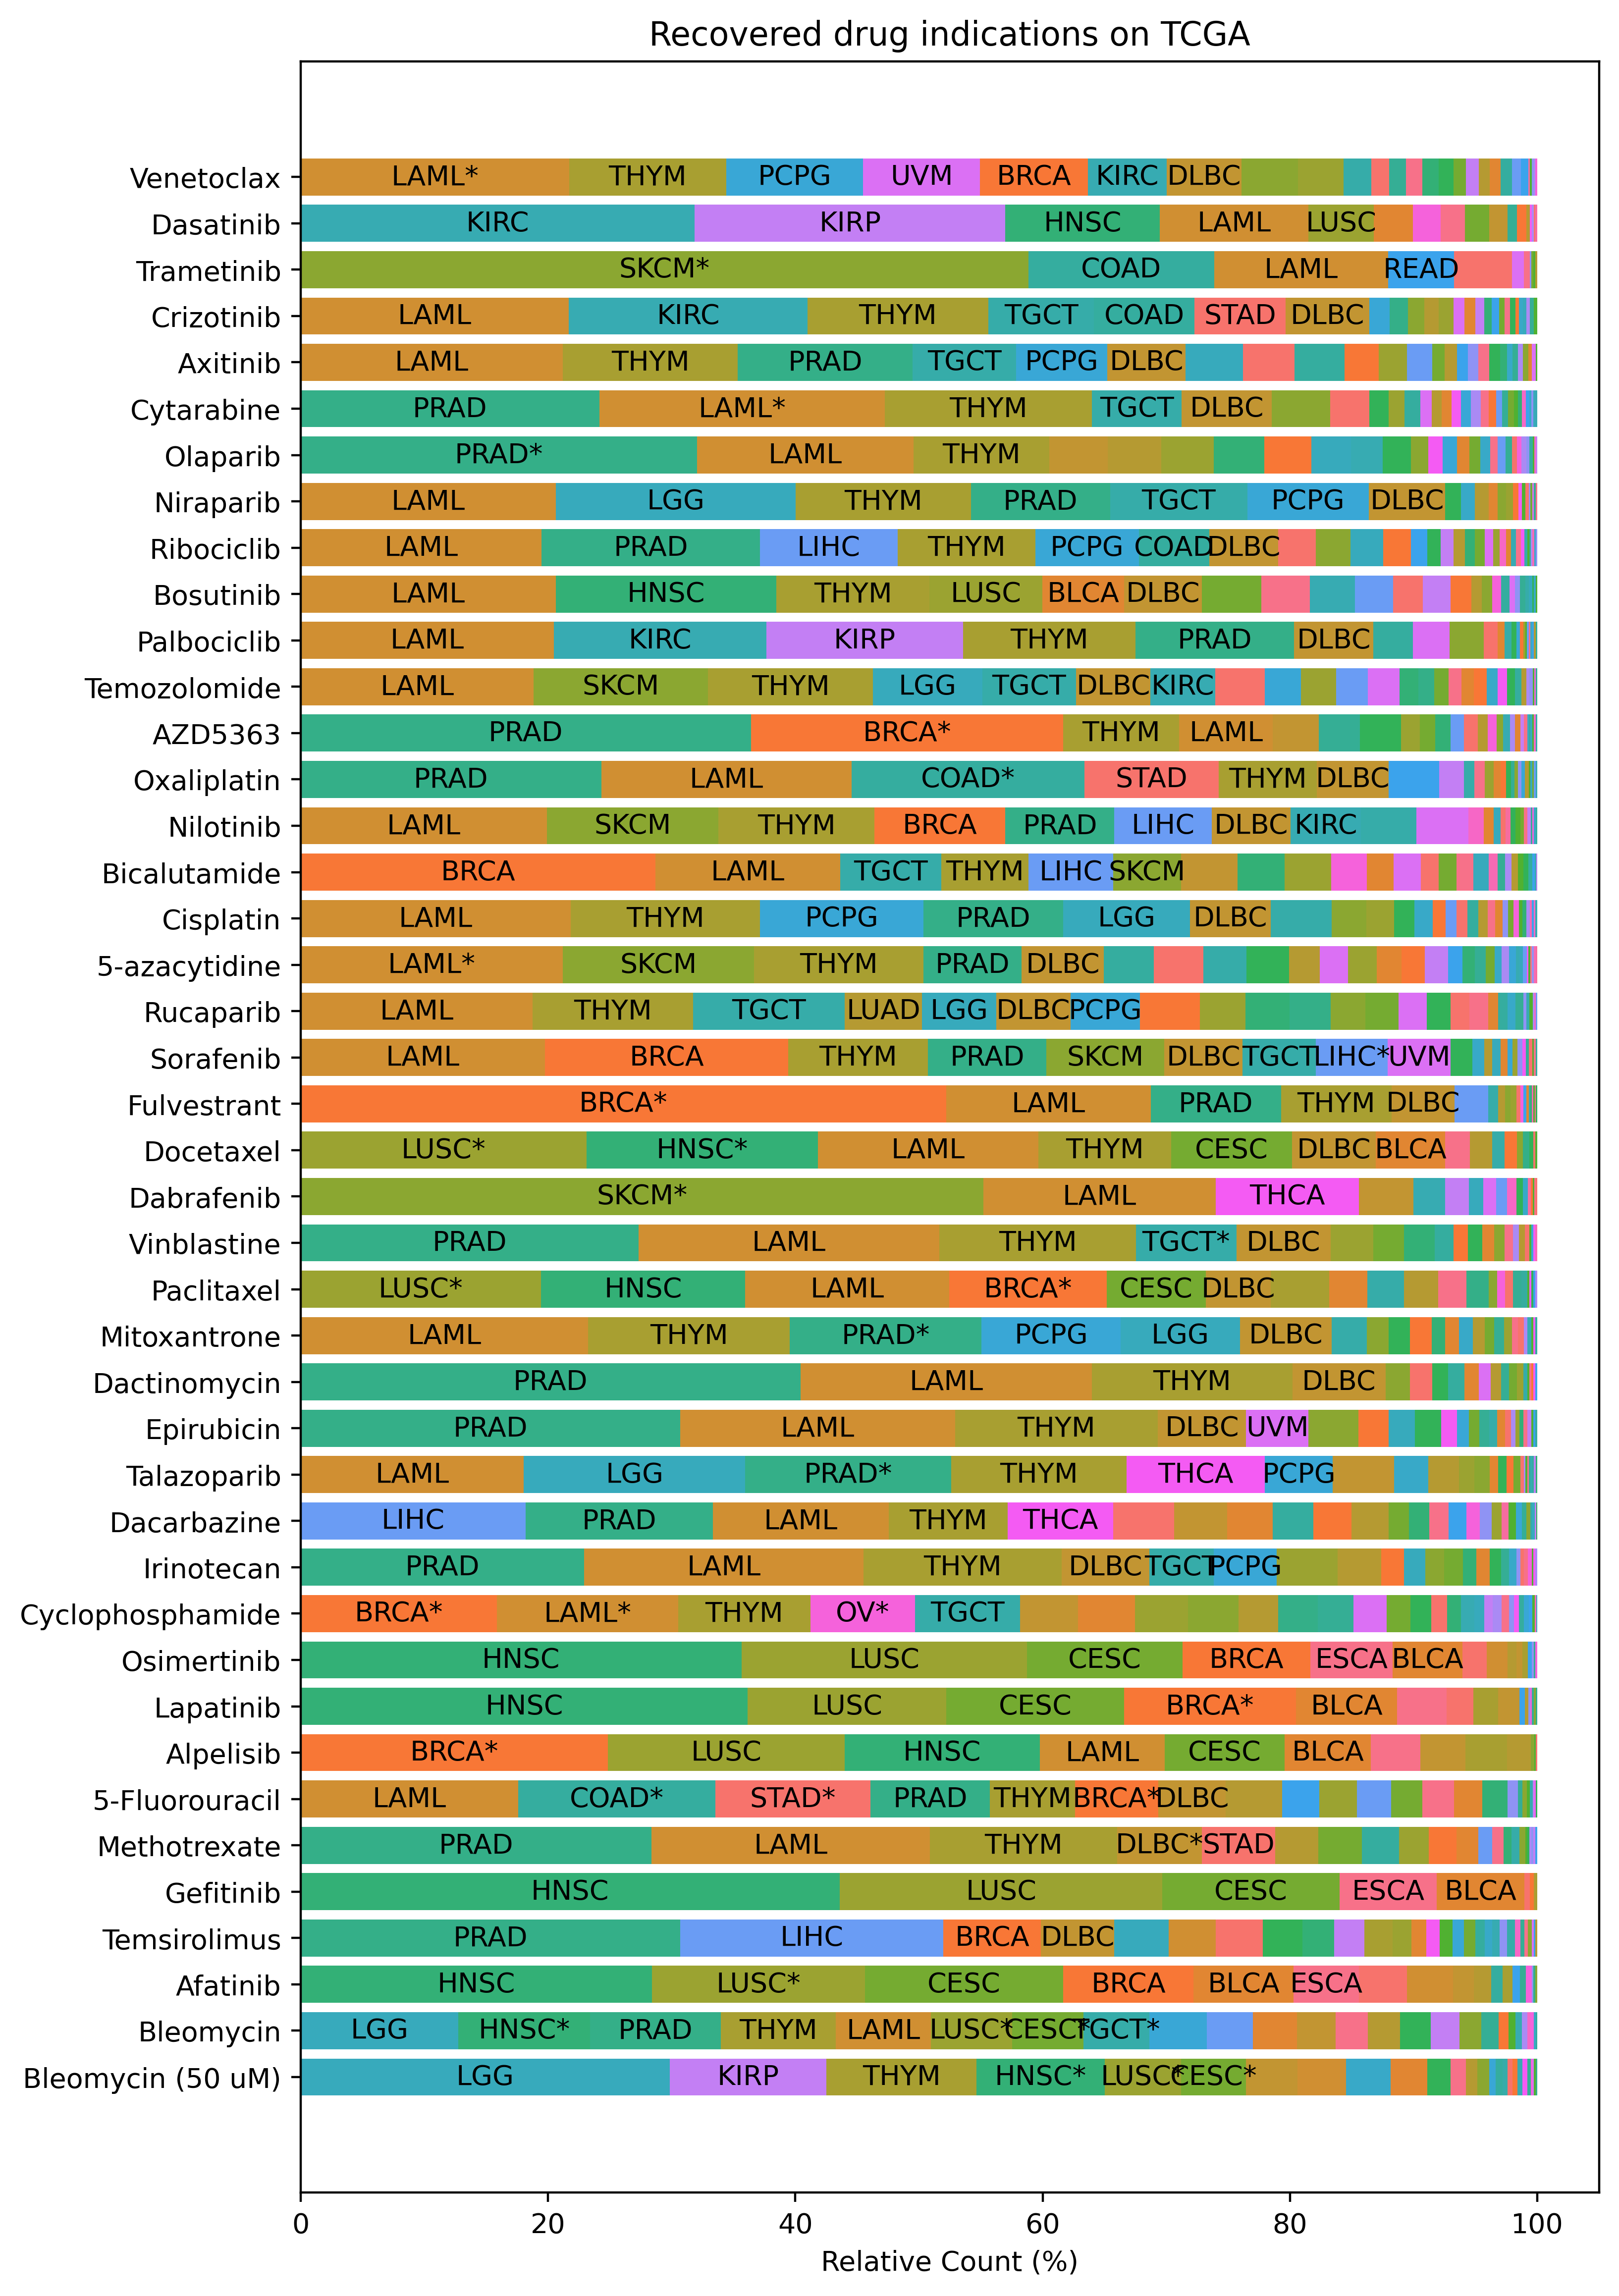

In [35]:
# Load the updated CSV file into a new DataFrame
updated_df = stacked_data

# Calculate the frequency of each unique project_id in the updated data
updated_project_id_frequency = updated_df['project_id'].value_counts().reset_index()
updated_project_id_frequency.columns = ['project_id', 'frequency']

# Sort the project IDs by frequency
sorted_project_ids_by_frequency_updated = updated_project_id_frequency.sort_values('frequency', ascending=False)['project_id'].values

# Generate a new colormap based on the sorted project IDs in the updated data
new_colormap_updated = sns.color_palette('husl', len(sorted_project_ids_by_frequency_updated))
new_project_id_to_color_updated = {project_id: color for project_id, color in zip(sorted_project_ids_by_frequency_updated, new_colormap_updated)}

# Calculate the sum of counts for each unique DrugName in the updated data
sum_counts_per_drug_updated = updated_df.groupby('DrugName')['count'].sum().reset_index()
sum_counts_per_drug_updated.rename(columns={'count': 'total_count'}, inplace=True)

# Merge the total count back into the updated DataFrame
updated_df = pd.merge(updated_df, sum_counts_per_drug_updated, on='DrugName')

# Calculate the relative count for each row in the updated data
updated_df['relative_count'] = (updated_df['count'] / updated_df['total_count']) * 100

# Re-create the plot using the new colormap and updated data
plt.figure(figsize=(8.27, 11.69), dpi=400)  # A4 size
plt.rcParams.update({'font.size': 10})

# Sort the data for better visualization
sorted_drug_names_updated = updated_df.groupby('DrugName')['total_count'].sum().sort_values(ascending=False).index
sorted_names = updated_df[['DrugName','Performance']].drop_duplicates().sort_values(by='Performance',ascending=True)['DrugName'].values

# Initialize variables to hold the current position of each bar
y_position = 0

# Iterate through each unique DrugName to plot the bars
for drug_name in sorted_names:
    drug_data = updated_df[updated_df['DrugName'] == drug_name]
    current_x = 0
    for idx, row in drug_data.iterrows():
        color = new_project_id_to_color_updated.get(row['project_id'], (0, 0, 0))  # Default to black if project_id is not in colormap
        plt.barh(y_position, row['relative_count'], left=current_x, color=color)
        
        # Add label if relative_count > 5%
        if row['relative_count'] > 5:
            label = row['project_id']
            if row['is_indication']:
                label += '*'
            plt.text(current_x + row['relative_count'] / 2, y_position, label, ha='center', va='center')
        
        current_x += row['relative_count']
    y_position += 1

# Add DrugName as y-ticks
plt.yticks(range(len(sorted_names)), labels=sorted_names)

# Additional plot settings
plt.xlabel('Relative Count (%)')
plt.title('Recovered drug indications on TCGA')
plt.tight_layout()

#plt.savefig(working_dir / 'stacked_indications_critunion_600_optimized.png', dpi=400)
#plt.savefig(working_dir / 'stacked_indications_critunion_600_optimized.svg', dpi=400)

# Save the plot
plt.show()

plt.close()


/tmp/ipykernel_72820/689073682.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles.append(Patch(color=color, label=row['project_id'],facecolor=color))


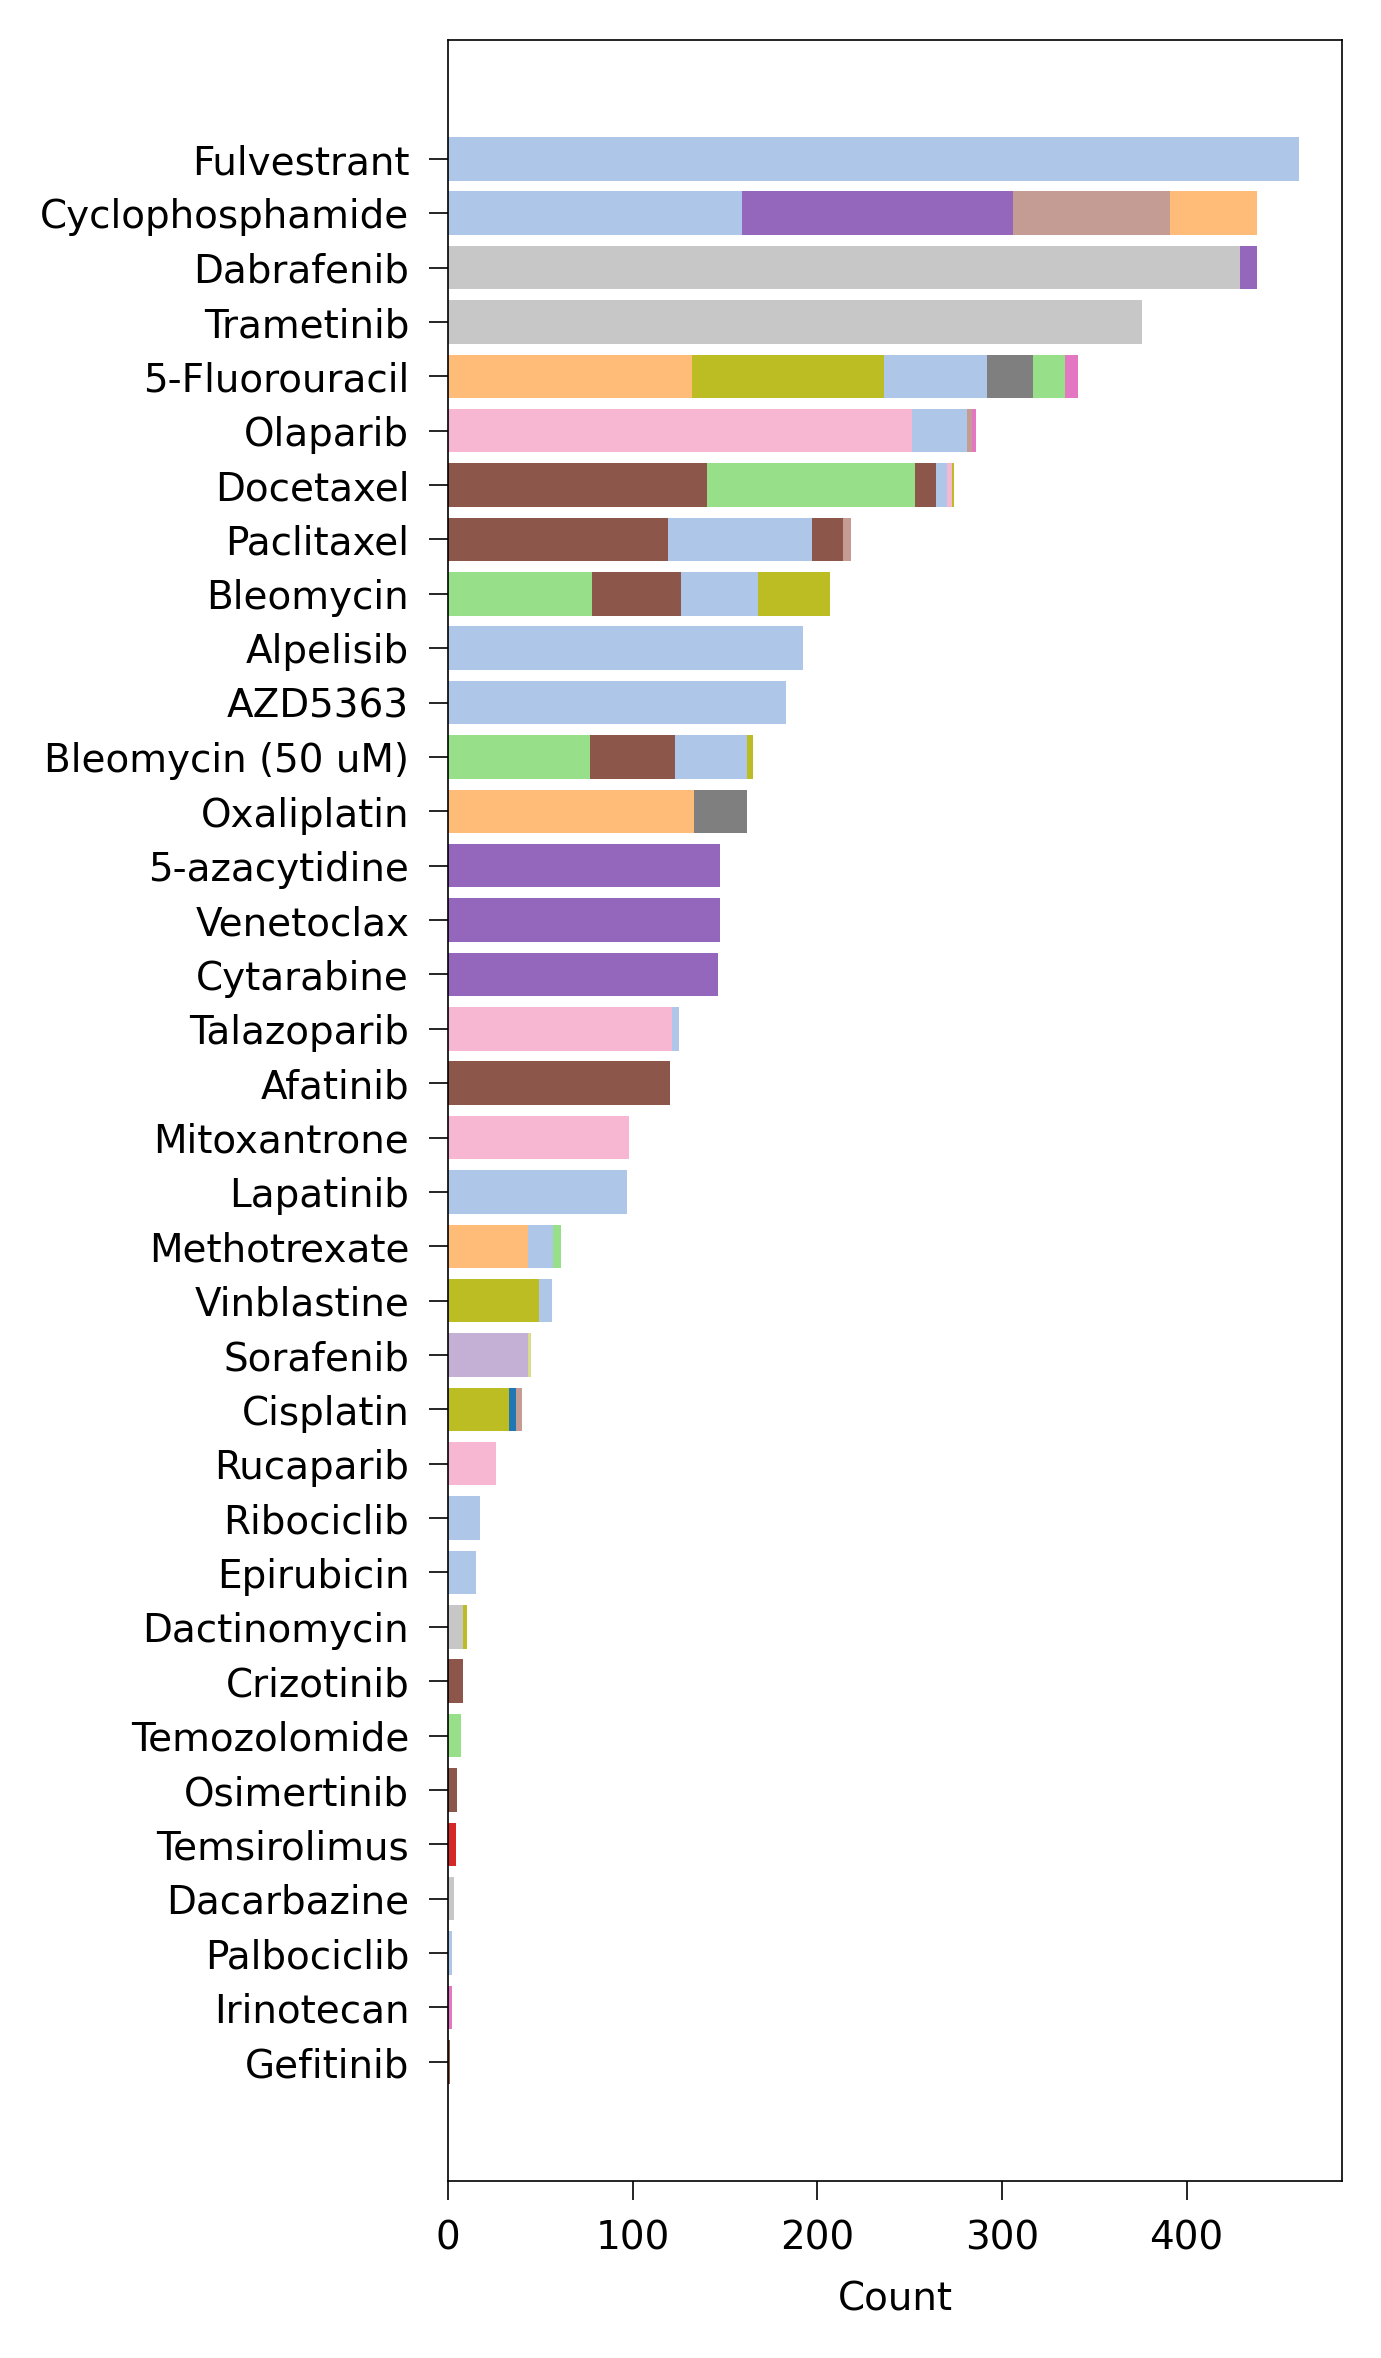

In [36]:
sub_stacked_data = stacked_data[stacked_data['is_indication']==True]

# Load the updated CSV file into a new DataFrame
updated_df = sub_stacked_data

# Calculate the frequency of each unique project_id in the updated data
updated_project_id_frequency = updated_df['project_id'].value_counts().reset_index()
updated_project_id_frequency.columns = ['project_id', 'frequency']

# Sort the project IDs by frequency
sorted_project_ids_by_frequency_updated = updated_project_id_frequency.sort_values('frequency', ascending=False)['project_id'].values

unique_p = list(project_dim_mapper.keys())
unique_p = sorted(unique_p)


new_colormap_updated = plt.cm.tab20(np.linspace(0, 1, len(unique_p)))
new_project_id_to_color_updated =  dict(zip(unique_p, new_colormap_updated))

# Calculate the sum of counts for each unique DrugName in the updated data
sum_counts_per_drug_updated = updated_df[['DrugName','count','both','ic50','quantile']].groupby('DrugName').sum().reset_index()
sum_counts_per_drug_updated.rename(columns={'count':'total_count','both': 'both_count','ic50': 'ic50_count','quantile': 'quantile_count'}, inplace=True)

# Merge the total count back into the updated DataFrame
updated_df = pd.merge(updated_df, sum_counts_per_drug_updated, on='DrugName')

# Initialize a list to hold unique legend handles
legend_handles = []
added_project_ids = set()  # Set to keep track of which project_ids have already been added to the legend

cti = 1/2.54

# Re-create the plot using the new colormap and updated data
plt.figure(figsize=(8.8*cti, 15*cti), dpi=400)  # A4 size
plt.rcParams.update({'font.size': 7})

# Sort the data for better visualization
sorted_drug_names_updated = updated_df[['DrugName','count']].groupby('DrugName')['count'].sum().sort_values(ascending=True).index

# Initialize variables to hold the current position of each bar
y_position = 0

# Iterate through each unique DrugName to plot the bars
for drug_name in sorted_drug_names_updated:
    drug_data = updated_df[updated_df['DrugName'] == drug_name]
    current_x = 0
    for idx, row in drug_data.iterrows():
        color = new_project_id_to_color_updated.get(row['project_id'], (0, 0, 0))  # Default to black
        plt.barh(y_position, row['count'], left=current_x, color=color)
        
        # Add to legend if this project_id hasn't been added yet
        if row['project_id'] not in added_project_ids:
            legend_handles.append(Patch(color=color, label=row['project_id'],facecolor=color))
            added_project_ids.add(row['project_id'])

        # (snipped: existing code for labels)
        
        current_x += row['count']
    y_position += 1

# Add DrugName as y-ticks
plt.yticks(range(len(sorted_drug_names_updated)), labels=sorted_drug_names_updated)

#get current axis
ax = plt.gca()

for axis in ['left','right','top','bottom']:
    ax.spines[axis].set_linewidth(0.3)

#set tick sizes
ax.tick_params(axis='both', which='major', width=0.3)

# Additional plot settings
plt.xlabel('Count')
plt.tight_layout()

#plt.savefig(working_dir / '6_C_stacked_indications_count_critunion_600_optimized.png', dpi=400)
#plt.savefig(working_dir / '6_C_stacked_indications_count_critunion_600_optimized.svg', dpi=400)

plt.show()

plt.close()

In [37]:
#updated_df.sort_values(by='total_count',ascending=False).to_csv(f'/home/fcarli/WebCellHit/analysis/local_data/{celligner_used}_stacked_indications.csv',index=False)

In [38]:
recall_dfs = []

for drug,tdf in updated_df.groupby('DrugName'):
    
    tdf['project_dim'] = tdf['project_id'].apply(lambda x: project_dim_mapper[x])
    recovered_both = tdf['both'].sum()
    recovered_ic50 = tdf['ic50'].sum()
    recovered_quantile = tdf['quantile'].sum()
    total = tdf['project_dim'].sum()

    recall_both = recovered_both/total
    recall_ic50 = recovered_ic50/total
    recall_quantile = recovered_quantile/total

    tdf = pd.DataFrame()
    tdf['DrugName'] = [drug]
    tdf['RecallBoth'] = [recall_both]
    tdf['RecallIC50'] = [recall_ic50]
    tdf['RecallQuantile'] = [recall_quantile]

    recall_dfs.append(tdf)

recall_dfs = pd.concat(recall_dfs)

recall_dfs['TotalRecall'] = recall_dfs['RecallBoth'] + recall_dfs['RecallIC50'] + recall_dfs['RecallQuantile']
recall_dfs.head()


,DrugName,RecallBoth,RecallIC50,RecallQuantile,TotalRecall
0,5-Fluorouracil,0.056457,0.007410,0.056457,0.120325
0,5-azacytidine,0.973510,0.000000,0.000000,0.973510
0,AZD5363,0.101370,0.000000,0.065753,0.167123
0,Afatinib,0.105108,0.000982,0.011788,0.117878
0,Alpelisib,0.094064,0.000000,0.081279,0.175342


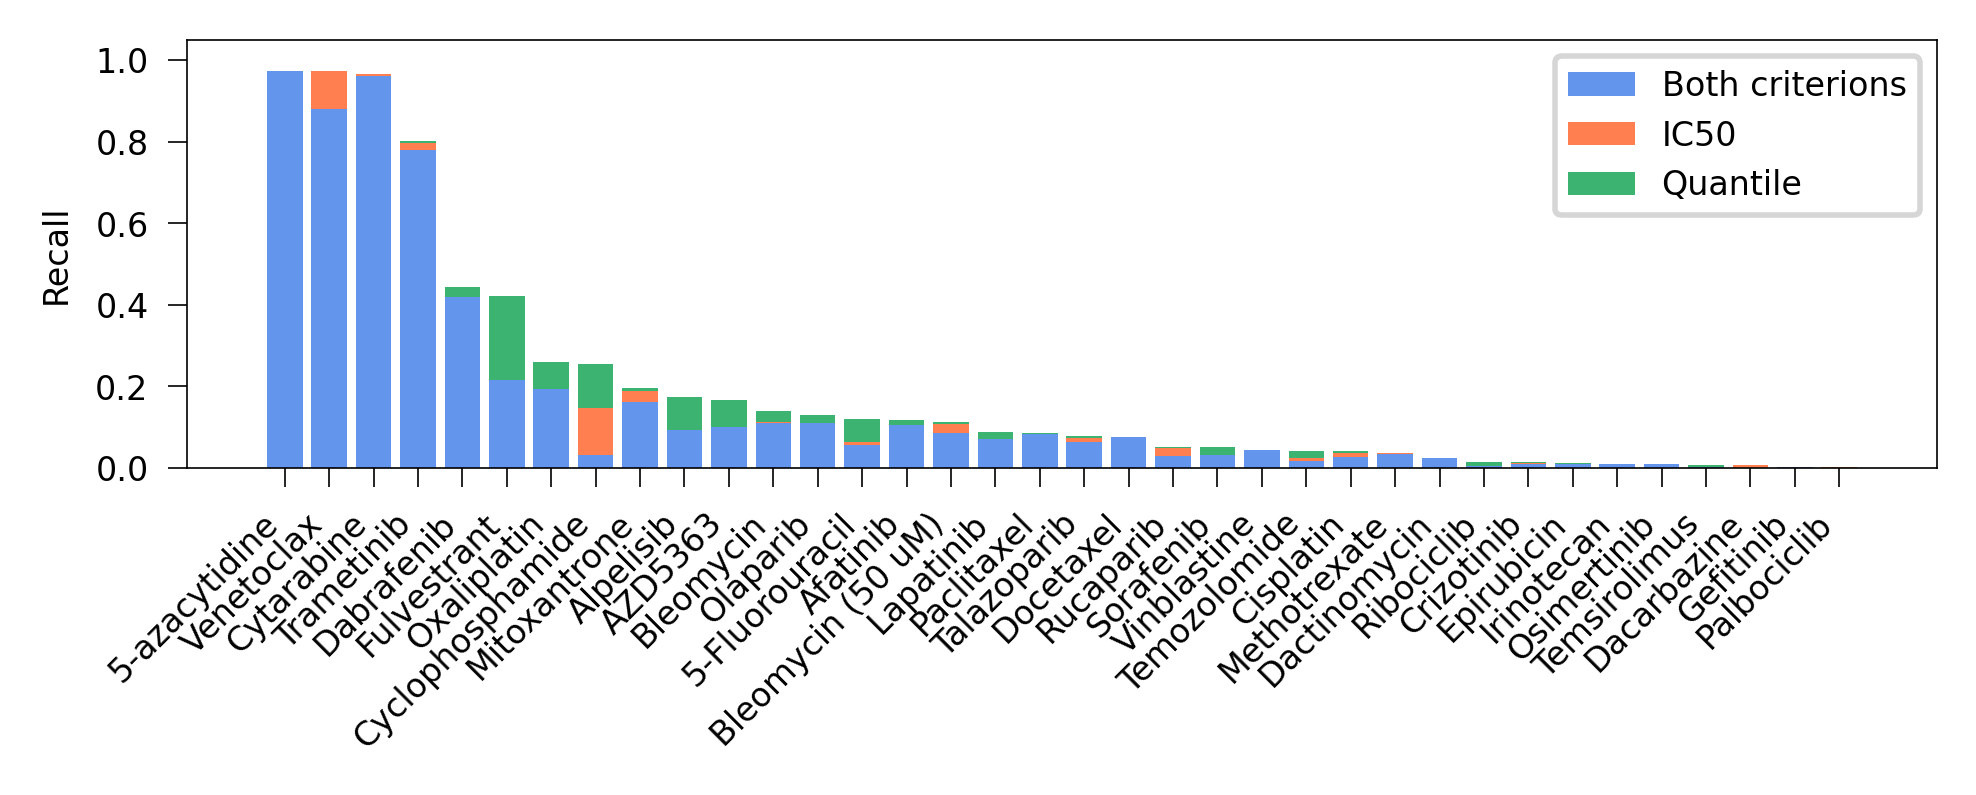

In [39]:
# Sort the DataFrame
recall_dfs = recall_dfs.sort_values(by='TotalRecall', ascending=False)

rec = recall_dfs.copy()
rec = rec.rename(columns={'RecallBoth':'Both criterions','RecallIC50':'IC50','RecallQuantile':'Quantile'})

cti = 1/2.54

# Set up the figure
plt.figure(figsize=(12.5*cti, 5*cti), dpi=400)
plt.rcParams.update({'font.size': 6})

# Initialize an array to keep track of the cumulative height
cumulative_height = np.zeros(len(rec))

for column, color in zip(['Both criterions','IC50', 'Quantile'],['cornflowerblue','coral','mediumseagreen']):
    # Plot the bar with the current cumulative height as the bottom
    plt.bar(rec['DrugName'].values, rec[column].values, 
            bottom=cumulative_height, label=column,color=color)
    # Update the cumulative height
    cumulative_height += rec[column].values

# Add legend, labels, title, and format axes
plt.legend(loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Recall')
plt.ylim(0, 1.05)
plt.tight_layout()

ax = plt.gca()

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.3)

plt.tick_params(axis='both', which='major', width=0.3)

#plt.savefig(working_dir / '6_B_recall_indications_critunion_600.png', dpi=400)
#plt.savefig(working_dir / '6_B_recall_indications_critunion_600.svg', dpi=400)

# Show the plot
plt.show()
